In [395]:
import networkx as nx
import pandas as pd
import numpy as np
import os

from collections import defaultdict
import reverse_geocode

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from stats import remove_isolates

In [415]:
# save plots
folder = "edge_analysis_plots"

# Create the folder if it doesn't exist
os.makedirs(folder, exist_ok=True)

In [ ]:
# preprocess data
G = nx.read_gexf('mto_author_interactions_collapsed.gexf')
G = remove_isolates(G)
nodes = list(G.nodes())

# remove indices without latitute and longitude components
indices_to_remove = [22, 32, 100, 110, 111, 169, 224, 277, 342, 383, 417, 461]
nodes_to_remove = [nodes[i] for i in indices_to_remove]
G.remove_nodes_from(nodes_to_remove)

In [418]:
def determine_us_region(state: str):
    
    """
    Determines the general US region (Western, Central, or Eastern) based on the state name.
    
    Input:
        state (str): Name of a US state.
    Output:
        str: Region name ('Western US', 'Central US', or 'Eastern US').
    """

    western = ['Washington', 'Oregon', 'California', 'Nevada', 'Idaho', 'Montana', 
               'Wyoming', 'Colorado', 'Utah', 'Arizona', 'New Mexico', 'Alaska', 'Hawaii']
    
    central = ['North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Minnesota', 
               'Iowa', 'Missouri', 'Wisconsin', 'Illinois', 'Michigan', 'Indiana', 
               'Ohio', 'Oklahoma', 'Texas', 'Arkansas']
    
    if state in western:
        return 'Western US'
    elif state in central:
        return 'Central US'
    else:
        return 'Eastern US'

def reverse_geocode_location_group(lat: float, lon: float):
    
    """
    Assigns a location group (region, country, or continent) based on latitude and longitude.
    Uses the reverse_geocode package to obtain location data (without using API)
    
    Inputs:
        lat (float): Latitude
        lon (float): Longitude
    Output:
        str: Location group (e.g., 'Western US', 'Canada', 'Europe', etc.)
    """

    result = reverse_geocode.get((lat, lon))
    
    country_code = result.get('country_code', '').upper()
    
    # For US, determine region based on state
    if country_code == 'US':
        state = result.get('state', '')
        return determine_us_region(state)
    
    if country_code == 'CA':
        return 'Canada'
    
    # Map country code to continent or region
    continent_mapping = {
        # Europe
        'AL': 'Europe', 'AD': 'Europe', 'AT': 'Europe', 'BY': 'Europe', 'BE': 'Europe',
        'BA': 'Europe', 'BG': 'Europe', 'HR': 'Europe', 'CY': 'Europe', 'CZ': 'Europe',
        'DK': 'Europe', 'EE': 'Europe', 'FI': 'Europe', 'FR': 'Europe', 'DE': 'Europe',
        'GR': 'Europe', 'HU': 'Europe', 'IS': 'Europe', 'IE': 'Europe', 'IT': 'Europe',
        'LV': 'Europe', 'LI': 'Europe', 'LT': 'Europe', 'LU': 'Europe', 'MT': 'Europe',
        'MD': 'Europe', 'MC': 'Europe', 'ME': 'Europe', 'NL': 'Europe', 'MK': 'Europe',
        'NO': 'Europe', 'PL': 'Europe', 'PT': 'Europe', 'RO': 'Europe', 'RU': 'Europe',
        'SM': 'Europe', 'RS': 'Europe', 'SK': 'Europe', 'SI': 'Europe', 'ES': 'Europe',
        'SE': 'Europe', 'CH': 'Europe', 'UA': 'Europe', 'GB': 'Europe', 'VA': 'Europe',
        'AX': 'Europe', 'GG': 'Europe', 'IM': 'Europe', 'JE': 'Europe', 'SJ': 'Europe',
        'FO': 'Europe',
        # Asia
        'AF': 'Asia', 'AM': 'Asia', 'AZ': 'Asia', 'BH': 'Asia', 'BD': 'Asia',
        'BT': 'Asia', 'BN': 'Asia', 'KH': 'Asia', 'CN': 'Asia', 'GE': 'Asia',
        'IN': 'Asia', 'ID': 'Asia', 'IR': 'Asia', 'IQ': 'Asia', 'IL': 'Asia',
        'JP': 'Asia', 'JO': 'Asia', 'KZ': 'Asia', 'KP': 'Asia', 'KR': 'Asia',
        'KW': 'Asia', 'KG': 'Asia', 'LA': 'Asia', 'LB': 'Asia', 'MY': 'Asia',
        'MV': 'Asia', 'MN': 'Asia', 'MM': 'Asia', 'NP': 'Asia', 'OM': 'Asia',
        'PK': 'Asia', 'PH': 'Asia', 'QA': 'Asia', 'SA': 'Asia', 'SG': 'Asia',
        'LK': 'Asia', 'SY': 'Asia', 'TW': 'Asia', 'TJ': 'Asia', 'TH': 'Asia',
        'TR': 'Asia', 'TM': 'Asia', 'AE': 'Asia', 'UZ': 'Asia', 'VN': 'Asia',
        'YE': 'Asia', 'HK': 'Asia', 'MO': 'Asia', 'PS': 'Asia', 'TL': 'Asia',
        'CX': 'Asia', 'CC': 'Asia', 'IO': 'Asia',
        # Africa
        'DZ': 'Africa', 'AO': 'Africa', 'BJ': 'Africa', 'BW': 'Africa', 'BF': 'Africa',
        'BI': 'Africa', 'CM': 'Africa', 'CV': 'Africa', 'CF': 'Africa', 'TD': 'Africa',
        'KM': 'Africa', 'CG': 'Africa', 'CD': 'Africa', 'DJ': 'Africa', 'EG': 'Africa',
        'GQ': 'Africa', 'ER': 'Africa', 'ET': 'Africa', 'GA': 'Africa', 'GM': 'Africa',
        'GH': 'Africa', 'GN': 'Africa', 'GW': 'Africa', 'CI': 'Africa', 'KE': 'Africa',
        'LS': 'Africa', 'LR': 'Africa', 'LY': 'Africa', 'MG': 'Africa', 'MW': 'Africa',
        'ML': 'Africa', 'MR': 'Africa', 'MU': 'Africa', 'MA': 'Africa', 'MZ': 'Africa',
        'NA': 'Africa', 'NE': 'Africa', 'NG': 'Africa', 'RE': 'Africa', 'RW': 'Africa',
        'SH': 'Africa', 'ST': 'Africa', 'SN': 'Africa', 'SC': 'Africa', 'SL': 'Africa',
        'SO': 'Africa', 'ZA': 'Africa', 'SS': 'Africa', 'SD': 'Africa', 'SZ': 'Africa',
        'TZ': 'Africa', 'TG': 'Africa', 'TN': 'Africa', 'UG': 'Africa', 'EH': 'Africa',
        'ZM': 'Africa', 'ZW': 'Africa', 'YT': 'Africa',
        # Oceania
        'AS': 'Oceania', 'AU': 'Oceania', 'CK': 'Oceania', 'FJ': 'Oceania', 'PF': 'Oceania',
        'GU': 'Oceania', 'KI': 'Oceania', 'MH': 'Oceania', 'FM': 'Oceania', 'NR': 'Oceania',
        'NC': 'Oceania', 'NZ': 'Oceania', 'NU': 'Oceania', 'NF': 'Oceania', 'MP': 'Oceania',
        'PW': 'Oceania', 'PG': 'Oceania', 'PN': 'Oceania', 'WS': 'Oceania', 'SB': 'Oceania',
        'TK': 'Oceania', 'TO': 'Oceania', 'TV': 'Oceania', 'VU': 'Oceania',
        # South America
        'AR': 'South America', 'BO': 'South America', 'BR': 'South America', 'CL': 'South America',
        'CO': 'South America', 'EC': 'South America', 'FK': 'South America', 'GF': 'South America',
        'GY': 'South America', 'PY': 'South America', 'PE': 'South America', 'SR': 'South America',
        'UY': 'South America', 'VE': 'South America', 'GS': 'South America',
        # North America
        'AI': 'North America', 'AG': 'North America', 'AW': 'North America', 'BS': 'North America',
        'BB': 'North America', 'BZ': 'North America', 'BM': 'North America', 'VG': 'North America',
        'KY': 'North America', 'CR': 'North America', 'CU': 'North America',
        'CW': 'North America', 'DM': 'North America', 'DO': 'North America', 'SV': 'North America',
        'GL': 'North America', 'GD': 'North America', 'GP': 'North America', 'GT': 'North America',
        'HT': 'North America', 'HN': 'North America', 'JM': 'North America', 'MQ': 'North America',
        'MX': 'North America', 'MS': 'North America', 'AN': 'North America', 'NI': 'North America',
        'PA': 'North America', 'PR': 'North America', 'BL': 'North America', 'KN': 'North America',
        'LC': 'North America', 'MF': 'North America', 'PM': 'North America', 'VC': 'North America',
        'SX': 'North America', 'TT': 'North America', 'TC': 'North America',
        'VI': 'North America',
        # Antartica
        'AQ': 'Antarctica', 'BV': 'Antarctica', 'TF': 'Antarctica', 'HM': 'Antarctica', 'GS': 'Antarctica',

    }
    
    return continent_mapping.get(country_code, 'Other')

In [419]:
def get_period_edges(G: nx.Graph, start: int, end: int):

    """
    Returns a list of edges in graph G where the 'year' attribute of the edge is between start and end (inclusive).
    
    Inputs:
        G (networkx.Graph): Graph with edges containing a 'year' attribute.
        start (int): Start year (inclusive).
        end (int): End year (inclusive).
    Output:
        list of (u, v): Edges active in the specified period.
    """
    
    period_edges = []
    for u, v, data in G.edges(data=True):
        if 'year' in data:
            paper_year = data['year']
            if start <= paper_year <= end:
                period_edges.append((u, v))
    return period_edges

In [ ]:
def analyze_geo_collaborations(G):

    """
    Analyzes collaborations in a graph by geographic region over time slices.
    For each time period, computes:
      - subgraph for the period
      - raw and normalized counts of collaborations between location groups
      - sizes of each location group
    
    Input:
        G (networkx.Graph): Graph with nodes containing 'latitude' and 'longitude', and edges with 'year' and optional 'weight'.
    Output:
        list of dict: Results for each period, including subgraph, period, raw counts, normalized values, and group sizes.
    """

    # Assign location groups using coordinate data from nodes
    for node, data in G.nodes(data=True):
        if 'latitude' in data and 'longitude' in data:
            data['location_group'] = reverse_geocode_location_group(float(data['latitude']), float(data['longitude']))
            # print(data['location_group'])
            
        else:
            data['location_group'] = 'Unknown'


    time_slices = [(y, y+2) for y in range(1993, 2024, 3)]
    results = []
    
    for start, end in time_slices:
        period_edges = get_period_edges(G, start, end)
        
        # Skip periods with no edges
        if not period_edges:
            continue
            
        H = G.edge_subgraph(period_edges)
        print(start,end, H)
        groups = nx.get_node_attributes(H, 'location_group')
        group_sizes = pd.Series(groups.values()).value_counts().to_dict()
        
        # Count collaborations between each pair of location groups
        edge_counts = defaultdict(int)
        for u, v in H.edges():
            g1 = H.nodes[u].get('location_group', 'Unknown')
            g2 = H.nodes[v].get('location_group', 'Unknown')
            #print(g1, g2)
            key = tuple(sorted((g1, g2)))
            edge_counts[key] += H[u][v].get('weight', 1.0)  # Use weight if exists
        
        normalized = {}
        total_edges = sum(edge_counts.values())

        for (g1, g2), count in edge_counts.items():
            # Normalize by total edges in the slice instead of possible connections
            normalized[(g1, g2)] = 100 * (count / total_edges) if total_edges > 0 else 0
        
        results.append({
            'subgraph': H,
            'period': (start, end),
            'raw_counts': dict(edge_counts),
            'normalized': normalized,
            'group_sizes': group_sizes
        })
    
    return results

In [421]:
analysis_results = analyze_geo_collaborations(G)

1993 1995 DiGraph with 11 nodes and 9 edges
1996 1998 DiGraph with 4 nodes and 4 edges
2002 2004 DiGraph with 4 nodes and 4 edges
2005 2007 DiGraph with 24 nodes and 24 edges
2008 2010 DiGraph with 45 nodes and 51 edges
2011 2013 DiGraph with 89 nodes and 104 edges
2014 2016 DiGraph with 142 nodes and 224 edges
2017 2019 DiGraph with 135 nodes and 172 edges
2020 2022 DiGraph with 206 nodes and 412 edges
2023 2025 DiGraph with 149 nodes and 276 edges


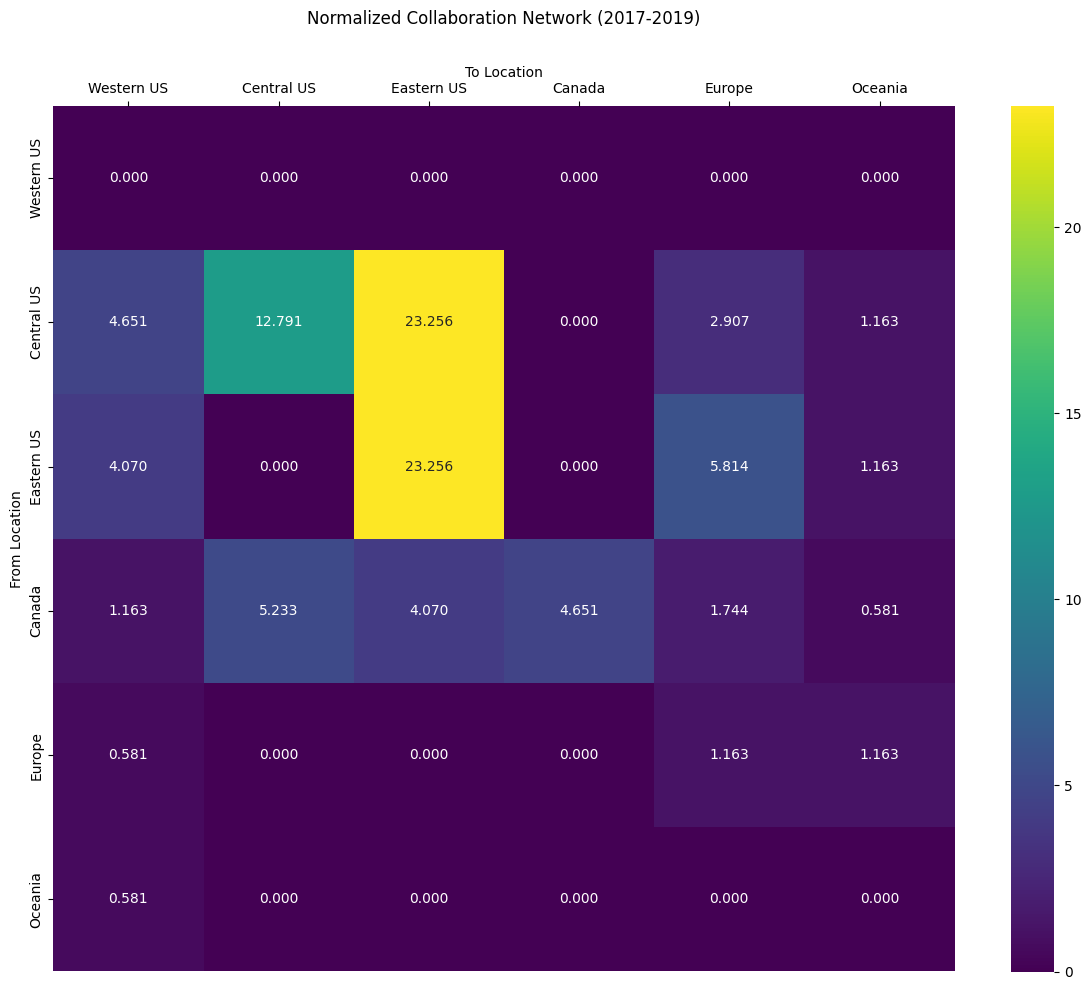

In [ ]:
# Choose which time slice to visualize
time_slice = analysis_results[-3]

# extract normalized data
normalized_data = time_slice['normalized']

all_locations = list(set([loc for pair in normalized_data.keys() for loc in pair]))

# custom order with Americas regions grouped together
americas_regions = ['Western US', 'Central US', 'Eastern US', 'Canada', 'South America']
other_regions = [loc for loc in all_locations if loc not in americas_regions]
custom_order = [loc for loc in americas_regions if loc in all_locations] + [loc for loc in other_regions]

heatmap_df = pd.DataFrame(0, 
                         index=custom_order,   # rows (g1 - from)
                         columns=custom_order, # columns (g2 - to)
                         dtype=float)


for (g1, g2), value in normalized_data.items():
    if g1 in heatmap_df.index and g2 in heatmap_df.columns:
        heatmap_df.at[g1, g2] = value

plt.figure(figsize=(12, 10))
ax = sns.heatmap(heatmap_df, annot=True, fmt='.3f', cmap='viridis')

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

plt.title(f'Normalized Collaboration Network ({time_slice["period"][0]}-{time_slice["period"][1]})', pad=30)
plt.xlabel(f'To Location')
plt.ylabel(f'From Location')
plt.tight_layout()

filename = f'Normalized Collaboration Network ({time_slice["period"][0]}-{time_slice["period"][1]}).png'
save_path = os.path.join(folder, filename)
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()


/var/folders/tj/r4pt7ctn78lggpm2r2r67psh0000gn/T/ipykernel_39230/3496374303.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = df.applymap(lambda x: f"{x:.2f}" if x != 0 else "")
/var/folders/tj/r4pt7ctn78lggpm2r2r67psh0000gn/T/ipykernel_39230/3496374303.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = df.applymap(lambda x: f"{x:.2f}" if x != 0 else "")
/var/folders/tj/r4pt7ctn78lggpm2r2r67psh0000gn/T/ipykernel_39230/3496374303.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = df.applymap(lambda x: f"{x:.2f}" if x != 0 else "")
/var/folders/tj/r4pt7ctn78lggpm2r2r67psh0000gn/T/ipykernel_39230/3496374303.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = df.applymap(lambda x: f"{x:.2f}" if x != 0 else "")
/var/folders/tj/r4pt7ctn78lggpm2r2r67psh0000gn/T/ipykernel_39230/3496374303.py:31: FutureWar

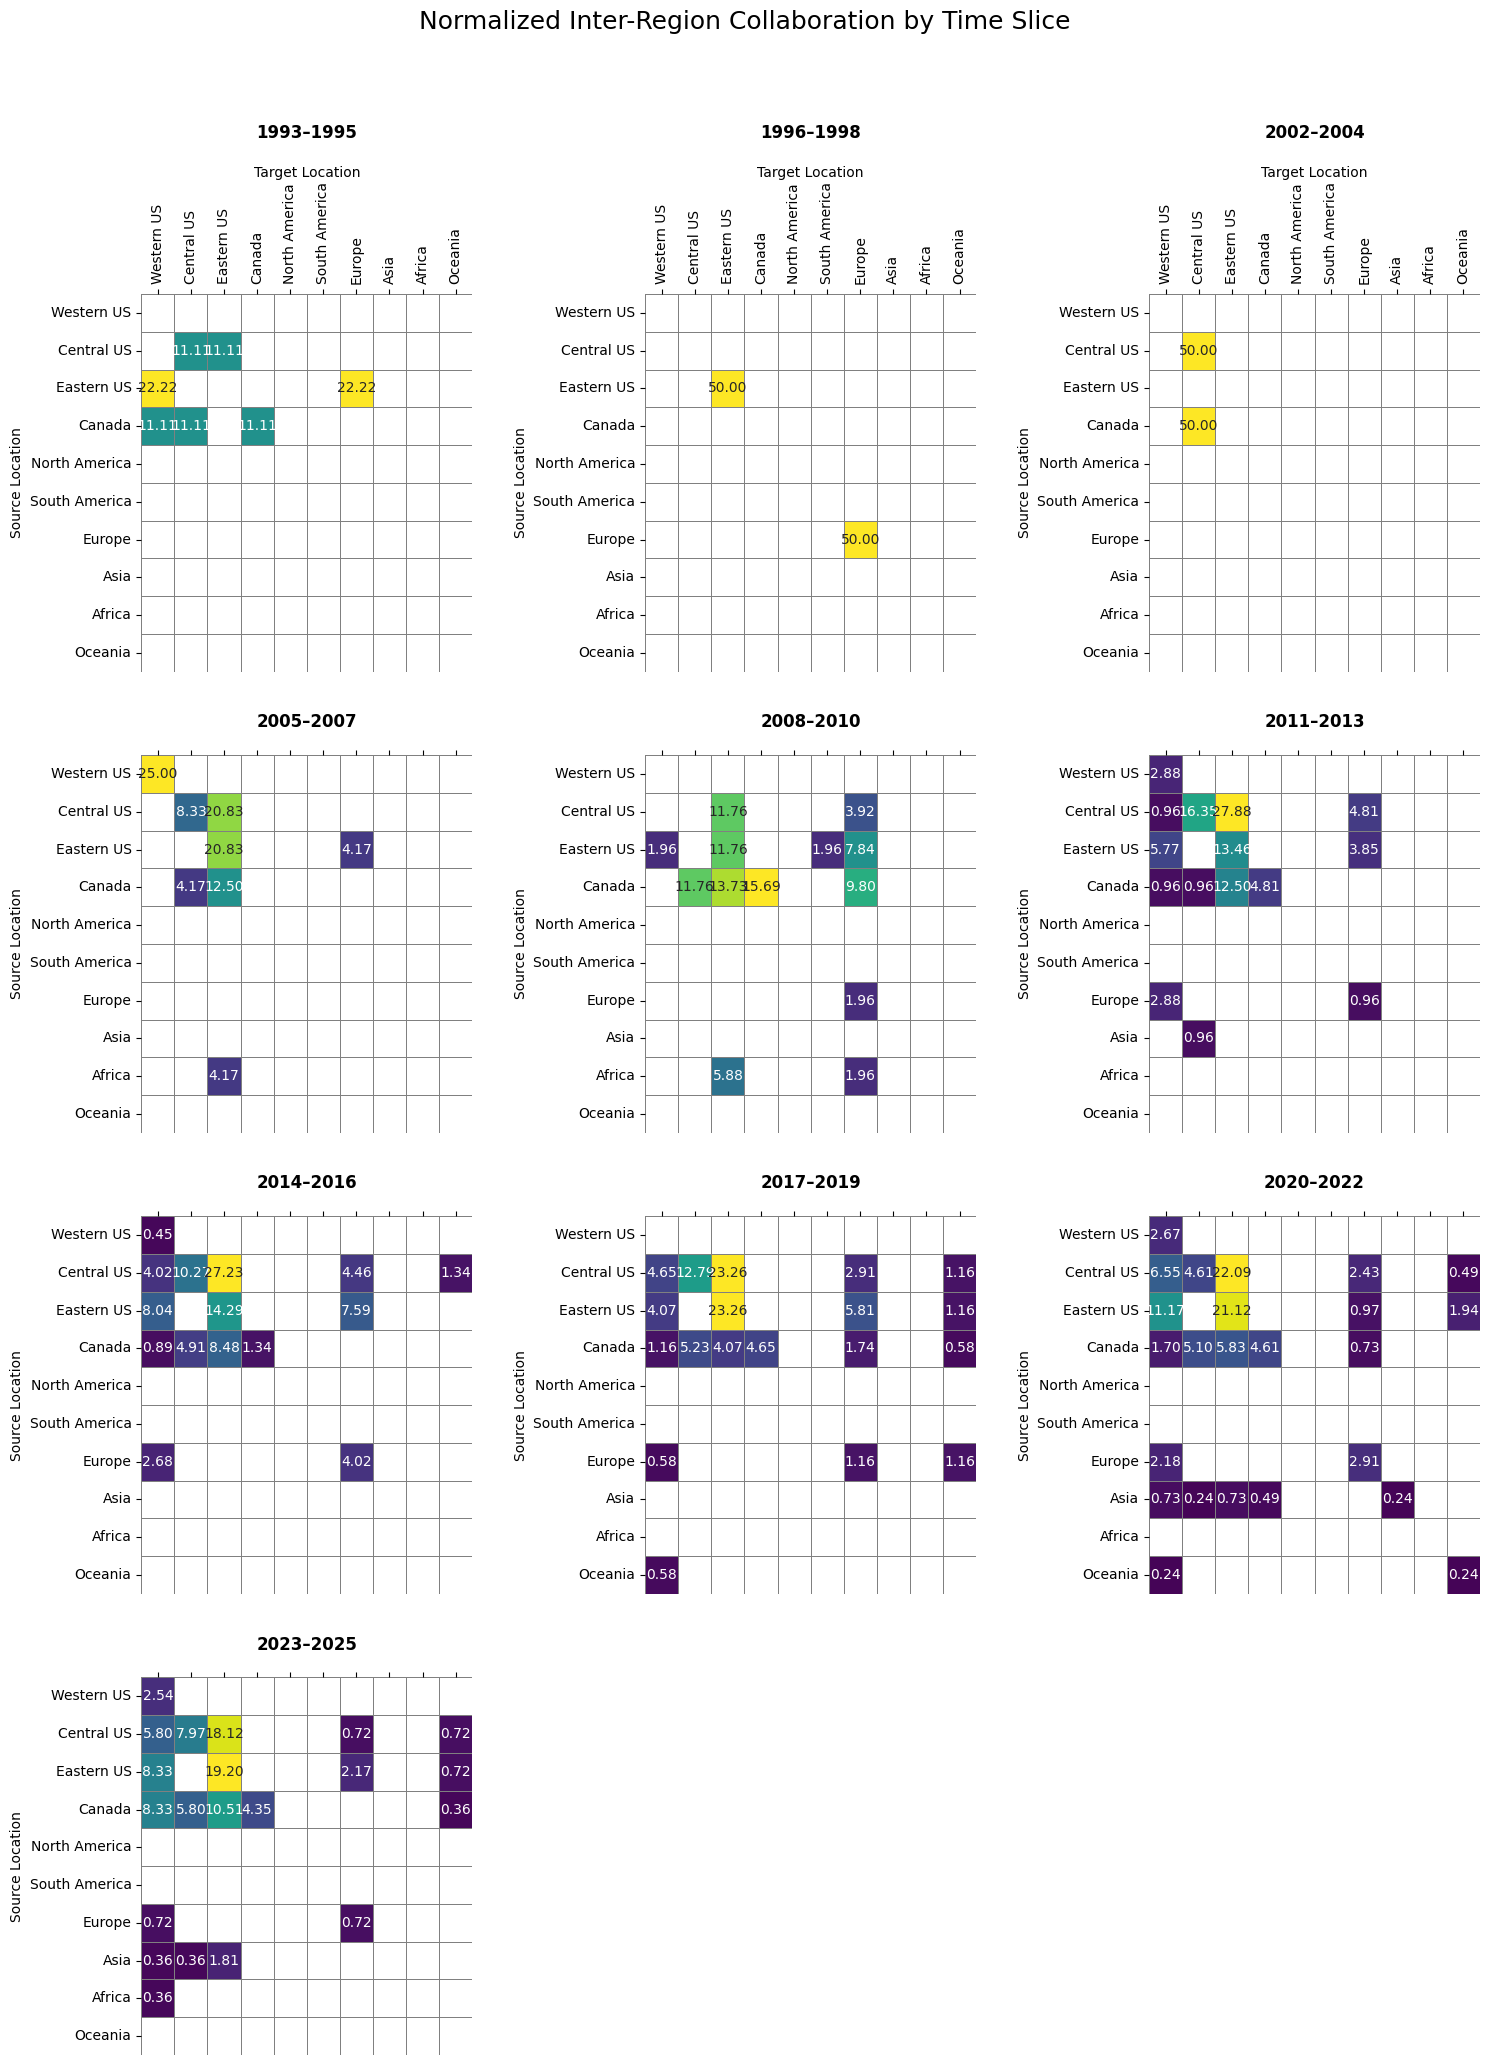

In [ ]:
# Plot normalized collaboration network graph for all time slices and display on one single graph

# Define region groupings for the heatmap axes
americas = ['Western US', 'Central US', 'Eastern US', 'Canada', 'North America', 'South America']
other_groups = ['Europe', 'Asia', 'Africa', 'Oceania', 'Other']
all_groups = americas + [g for g in other_groups if any(g in r['group_sizes'] for r in analysis_results)]

n_slices = len(analysis_results)
ncols = 3  # Number of columns in the subplot grid
nrows = int(np.ceil(n_slices / ncols))

# Create a custom colormap, where zero values are white
base_cmap = plt.cm.viridis
colors = base_cmap(np.linspace(0, 1, 256))
colors[0] = np.array([1, 1, 1, 1])  # Set the first color (for 0) to white
custom_cmap = LinearSegmentedColormap.from_list('custom_viridis', colors)

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))

axes = axes.flatten() if n_slices > 1 else [axes]

for idx, time_slice in enumerate(analysis_results):
    ax = axes[idx]
    row_idx = idx // ncols

    norm = time_slice['normalized']
    # Build DataFrame for heatmap
    df = pd.DataFrame(0, index=all_groups, columns=all_groups, dtype=float)
    for (g1, g2), val in norm.items():
        if g1 in df.index and g2 in df.columns:
            df.at[g1, g2] = val

    # show value if nonzero, else blank
    annot = df.applymap(lambda x: f"{x:.2f}" if x != 0 else "")

    # Plot heatmap with custom colormap and annotation
    sns.heatmap(
        df, ax=ax, cmap=custom_cmap, annot=annot, fmt="", cbar=False,
        linewidths=0.5, linecolor='gray'
    )

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

    # Only show x-axis labels for the top row
    if row_idx > 0:
        ax.set_xlabel('')
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Target Location')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')

    ax.set_title(f"{time_slice['period'][0]}–{time_slice['period'][1]}", pad=20, fontweight='bold')
    ax.set_ylabel('Source Location')


for i in range(len(analysis_results), len(axes)):
    fig.delaxes(axes[i])

fig.suptitle('Normalized Inter-Region Collaboration by Time Slice', fontsize=18, y=1.03)
fig.tight_layout(h_pad=3.0, w_pad=3.0)

filename = 'Normalized Inter-Region Collaboration by Time Slice.png'
save_path = os.path.join(folder, filename)
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

In [392]:
select_graph = analysis_results[4]['subgraph']
time_period = analysis_results[4]['period']

select_graph_node_attributes = {node: data for node, data in select_graph.nodes(data=True)}

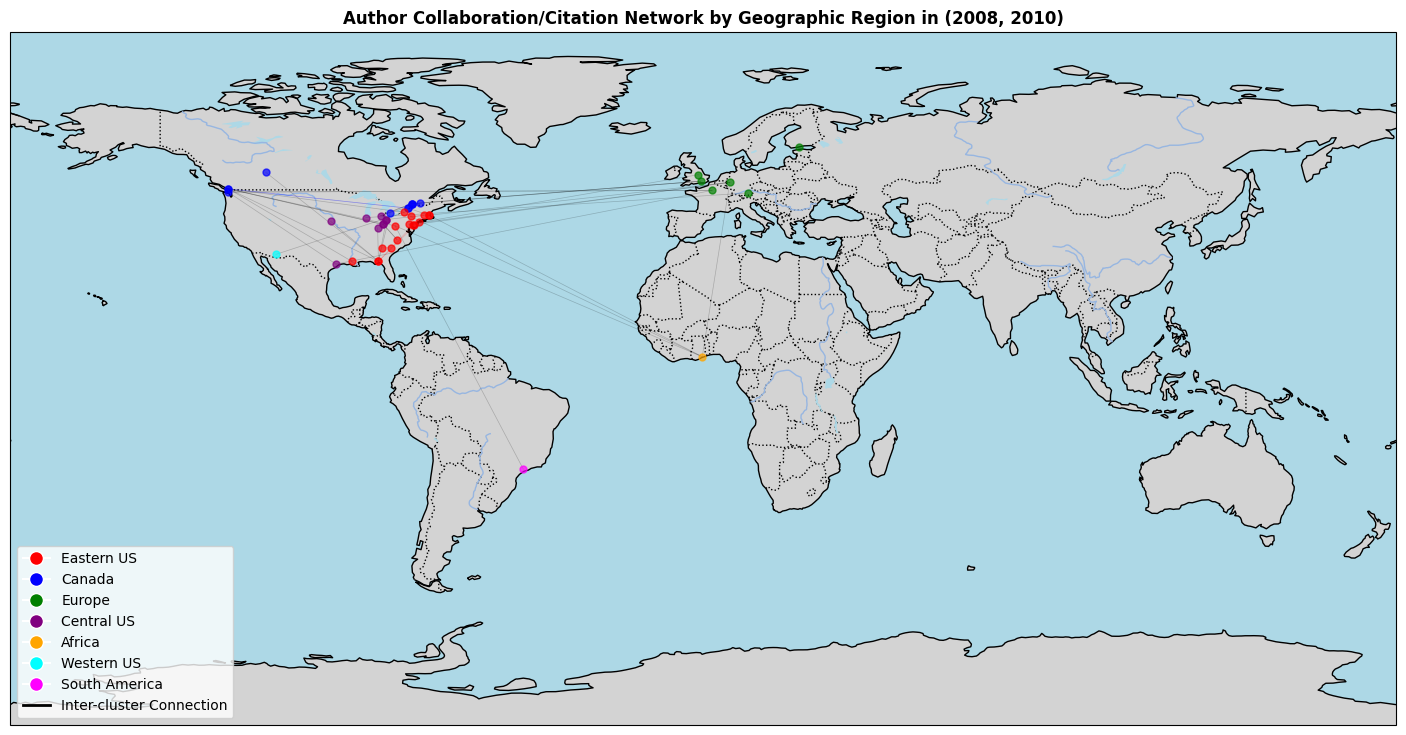

In [ ]:
# Plot select time slice data geographically on the world map, to visualize the intra and inter geographic cluster edges

# Create a dictionary mapping location groups to color indices
location_to_color = {}
color_idx = 0

plt.figure(figsize=(18, 9))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.LAKES, facecolor='lightblue')
ax.add_feature(cfeature.RIVERS)

cluster_colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow']

pos = {
    k: (float(v['longitude']), float(v['latitude']))
    for k, v in select_graph_node_attributes.items()
    if v.get('latitude') and v.get('longitude')
}

for node in select_graph.nodes():
    if node in pos:
        location = select_graph_node_attributes[node].get('location_group', 'Unknown')
        
        if location not in location_to_color:
            location_to_color[location] = color_idx
            color_idx = (color_idx + 1) % len(cluster_colors)

for u, v in select_graph.edges():
    # make sure both nodes have positions
    if u in pos and v in pos:
        lon1, lat1 = pos[u]
        lon2, lat2 = pos[v]
        
        location_u = select_graph_node_attributes[u].get('location_group', 'Unknown')
        location_v = select_graph_node_attributes[v].get('location_group', 'Unknown')

        if location_u == location_v:
            edge_color = cluster_colors[location_to_color[location_u]]
        else:
            # different clusters - use black
            edge_color = 'black'
                
        ax.plot([lon1, lon2], [lat1, lat2], color=edge_color, 
                alpha=0.2, linewidth=0.5, transform=ccrs.PlateCarree())

for node in select_graph.nodes():
    if node in pos:
        location = select_graph_node_attributes[node].get('location_group', 'Unknown')
        color = cluster_colors[location_to_color[location]]
        lon, lat = pos[node]
        ax.plot(lon, lat, 'o', color=color, markersize=5, alpha=0.7)

legend_elements = []
for location, color_idx in location_to_color.items():
    color = cluster_colors[color_idx]
    legend_elements.append(Line2D([0], [0], marker='o', color='w', 
                                  markerfacecolor=color, markersize=10, 
                                  label=f'{location}'))

# Legend entry for inter-cluster edges
legend_elements.append(Line2D([0], [0], color='black', lw=2, label='Inter-cluster Connection'))

ax.legend(handles=legend_elements, loc='lower left', fontsize=10)

plt.title(f'Author Collaboration/Citation Network by Geographic Region in {time_period}', fontweight = "bold")

filename = f'Author Interaction Network by Geographic Region {time_period}.png'
save_path = os.path.join(folder, filename)
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

# geo-based random walk

In [ ]:
# create folder for geo-based random walk
geo_folder = "geo_random_walk_plots"

# Create the folder if it doesn't exist
os.makedirs(geo_folder, exist_ok=True)

In [ ]:
def compute_random_walk_centrality(G: nx.Graph, transition_data, alpha = 0.85, max_iter = 100):
    
    """
    Compute geo-biased random walk centrality using power iteration.
    
    Inputs:
        G (networkx.Graph)
        transition_data: Precomputed transition matrix and node list
        alpha (float) : Damping factor (1 - teleport probability)
        max_iter (int) : Maximum iterations for convergence
    Output:
        dict: Node centrality scores representing stationary probabilities
    """
    
    P, nodes = transition_data
    n = len(nodes)
    
    # init centrality vector
    centrality = np.ones(n) / n
    
    # power iteration to compute stationary distribution
    for _ in range(max_iter):
        old_centrality = centrality.copy()
        
        # update with biased random walk step + teleportation
        centrality = alpha * np.dot(centrality, P) + (1 - alpha) / n
        
        # convergence checks
        if np.linalg.norm(centrality - old_centrality) < 1e-6:
            break
    
    return {nodes[i]: float(centrality[i]) for i in range(n)}

In [ ]:
def identify_global_bridges(G: nx.Graph, location_groups, centrality):
    
    """
    Identify nodes bridging different geographic regions using modified bridgeness metric.
    
    Inputs:
        G (networkx.Graph): Graph with edges containing a 'location_group' attribute.
        location_groups: Dict mapping nodes to geographic regions
        centrality: Precomputed node centrality scores (in this case from compute_random_walk_centrality())
    Output:
        dict: Bridge scores for each node combining connectivity and centrality
    """

    bridges = {}
    
    for node in G.nodes():
        if G.degree(node) == 0:
            bridges[node] = 0
            continue
        
        node_region = location_groups.get(node, 'Unknown')
        
        # count connections to different regions
        region_connections = defaultdict(int)
        total_connections = 0
        
        for neigh in G.neighbors(node):
            neigh_region = location_groups.get(neigh, 'Unknown')
            region_connections[neigh_region] += 1
            total_connections += 1
        
        # calc metrics
        external_connections = sum(count for region, count in region_connections.items() 
                                if region != node_region)
        num_regions_connected = len(region_connections) - (1 if node_region in region_connections else 0)
        
        # Bridgeness calculation: combines centrality with cross-region connectivity
        if total_connections > 0:
            region_diversity = num_regions_connected / max(1, len(set(location_groups.values())) - 1)
            external_ratio = external_connections / total_connections
            
            # Combine with random walk centrality for final score
            bridges[node] = (external_ratio * region_diversity * centrality[node] * 10)
        else:
            bridges[node] = 0
    
    return bridges

In [ ]:
def compute_region_influence(G: nx.Graph, centrality, location_groups):
    
    """
    Calculate regional influence metrics including cross-region flow.
    
    Inputs:
        G (networkx.Graph): Graph with edges containing a 'location_group' attribute.
        centrality: Node centrality scores
        location_groups: Dict mapping nodes to regions
    Output:
        dict: Contains total/avg influence per region and cross-region flow matrix
    """

    # group centrality by region
    region_total = defaultdict(float)
    region_count = defaultdict(int)
    
    for node, score in centrality.items():
        region = location_groups.get(node, 'Unknown')
        region_total[region] += score
        region_count[region] += 1
    
    # calc aggregate metrics
    region_metrics = {
        'total_influence': dict(region_total),
        'avg_influence': {r: region_total[r]/region_count[r] for r in region_total},
        'node_count': dict(region_count)
    }
    
    # calc influence flow between regions
    influence_flow = defaultdict(float)
    for u, v in G.edges():
        u_region = location_groups.get(u, 'Unknown')
        v_region = location_groups.get(v, 'Unknown')
        
        if u_region != v_region:
            # calc flow as product of centralities
            flow = centrality[u] * centrality[v]
            influence_flow[(u_region, v_region)] = influence_flow.get((u_region, v_region), 0) + flow
    
    region_metrics['influence_flow'] = dict(influence_flow)
    return region_metrics

In [ ]:
def visualize_region_influence_evolution(start : int, end : int, results):
    
    """
    Generate line plot showing average regional influence over time periods.
    
    Inputs:
        start (int): First year in analysis
        end (int): Last year in analysis
        results: Analysis results from implement_geo_biased_random_walks()
    """

    periods = [f"{r['period'][0]}-{r['period'][1]}" for r in results]
    
    all_regions = set()
    for r in results:
        all_regions.update(r['region_influence']['avg_influence'].keys())
    
    # prep timeseries data for each region
    region_data = {region: [] for region in all_regions}
    for r in results:
        influence = r['region_influence']['avg_influence']
        for region in all_regions:
            region_data[region].append(influence.get(region, 0))
    
    # plot evolution
    plt.figure(figsize=(14, 8))
    for region, values in region_data.items():
        plt.plot(periods, values, 'o-', label=region)
    
    plt.title('Evolution of Regional Influence Over Time')
    plt.xlabel('Time Period')
    plt.ylabel('Average Influence per Node')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    filename = f"Evolution of Regional Influence Over Time ({start}-{end}).png"
    save_path = os.path.join(geo_folder, filename)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()


In [ ]:
def create_geo_biased_transition_matrix(G: nx.Graph, location_groups, penalty_factor=0.3):
    
    """
    Generate transition probability matrix with reduced cross-region transitions.
    
    Inputs:
        G (networkx.Graph): Graph with edges containing a 'location_group' attribute.
        location_groups: Dict mapping nodes to regions
        penalty_factor: Multiplier for cross-region transition probabilities
    Output:
        tuple: (Transition matrix, node list)
    """
    
    nodes = list(G.nodes())
    n = len(nodes)
    node_idx = {node: i for i, node in enumerate(nodes)}
    
    # init transition matrix
    P = np.zeros((n, n))
    
    for node in nodes:
        neighbors = list(G.neighbors(node))
        if not neighbors:
            continue
            
        node_region = location_groups.get(node, 'Unknown')
        i = node_idx[node]
        
        # calc weighted transition probabilities with geo-penalty
        trans_probs = []
        for neigh in neighbors:
            neigh_region = location_groups.get(neigh, 'Unknown')
            j = node_idx[neigh]
            
            # Apply penalty for cross-region transitions
            if node_region != neigh_region:
                weight = penalty_factor
            else:
                weight = 1.0  # Same region
                
            trans_probs.append((j, weight))
        
        # Normalize to get probability distribution
        total_weight = sum(w for _, w in trans_probs)
        if total_weight > 0:
            for j, weight in trans_probs:
                P[i, j] = weight / total_weight
    
    return P, nodes

In [ ]:
def implement_geo_biased_random_walks(G : nx.Graph, time_slices, penalty_factor=0.3):
    
    """
    Main pipeline for computing geographic-biased centrality metrics across time periods.
    
    Inputs:
        G (networkx.Graph)
        time_slices: List of (start_year, end_year) tuples
        penalty_factor: Cross-region transition penalty
    Output:
        list: Analysis results per time period containing centrality, bridges, and influence metrics
    """
    
    results = []
    
    for start_year, end_year in time_slices:
        # create subgraph for this time period
        period_edges = get_period_edges(G, start_year, end_year)
        
        # Skip periods with no edges
        if not period_edges:
            continue
            
        H = G.edge_subgraph(period_edges)
        location_groups = nx.get_node_attributes(H, 'location_group')
        
        # compute biased transition matrix
        trans_matrix = create_geo_biased_transition_matrix(H, location_groups, penalty_factor)
        
        # compute random walk centrality
        rw_centrality = compute_random_walk_centrality(H, trans_matrix)
        
        # identify global bridges
        bridges = identify_global_bridges(H, location_groups, rw_centrality)
        
        # calc regional influence metrics
        region_influence = compute_region_influence(H, rw_centrality, location_groups)
        
        results.append({
            'period': (start_year, end_year),
            'subgraph': H,
            'centrality': rw_centrality,
            'bridges': bridges,
            'region_influence': region_influence
        })
    
    return results

In [ ]:
def visualize_bridges(results_slice, top_n=10):

    """
    Visualize network with top bridge nodes highlighted.
    
    Inputs:
        results_slice: Single time period analysis results
        top_n: Number of top bridges to highlight
    """
    
    H = results_slice['subgraph']
    bridges = results_slice['bridges']
    period = results_slice['period']
    location_groups = nx.get_node_attributes(H, 'location_group')
    
    top_bridges = sorted(bridges.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    pos = nx.spring_layout(H, seed=42)
    
    regions = set(location_groups.values())
    cmap = plt.cm.tab10
    region_colors = {r: cmap(i/len(regions)) for i, r in enumerate(regions)}
    
    plt.figure(figsize=(12, 10))
    
    for region in regions:
        nodes = [n for n in H.nodes() if location_groups.get(n) == region]
        nx.draw_networkx_nodes(H, pos, nodelist=nodes, 
                              node_color=[region_colors[region]],
                              label=region, alpha=0.7)
    
    # highlight bridge nodes
    bridge_nodes = [node for node, _ in top_bridges]
    nx.draw_networkx_nodes(H, pos, nodelist=bridge_nodes, 
                          node_color='red', node_size=200, 
                          label='Global Bridges')
    
    nx.draw_networkx_edges(H, pos, alpha=0.1)
    
    labels = {node: node for node, _ in top_bridges}
    nx.draw_networkx_labels(H, pos, labels=labels, font_size=8)
    
    plt.title(f"Global Bridges ({period[0]}-{period[1]})")
    plt.legend()
    plt.axis('off')
    plt.tight_layout()

    filename = f"Global Bridges ({period[0]}-{period[1]}).png"
    save_path = os.path.join(geo_folder, filename)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

In [ ]:
def global_bridges(start: int = 1993, end : int = 2024, only_evo : bool = False):

    """
    Entry point for global bridge analysis with visualization options: can pick start and end dates.
    
    Inputs:
        start (int): First analysis year, defaults to 1993
        end (int): Last analysis year, defaults to 2024
        only_evo (bool): If True, only show influence evolution plot
    """

    time_slices = [(y, y+2) for y in range(start, end, 3)]
    
    results = implement_geo_biased_random_walks(G, time_slices, penalty_factor=0.3)
    
    # give option to only get evolution graph or all the visualizations
    if only_evo == False: 
        visualize_region_influence_evolution(start, end, results)
    
        # Output top global bridges for each period
        for r in results:
            period = r['period']
            print(f"\nPeriod: {period[0]}-{period[1]}")
            
            top_bridges = sorted(r['bridges'].items(), key=lambda x: x[1], reverse=True)[:5]
            print("Top global bridges:")
            for node, score in top_bridges:
                location = nx.get_node_attributes(r['subgraph'], 'location_group').get(node)
                print(f"  - {node} (Region: {location}, Bridge Score: {score:.4f})")
            
            visualize_bridges(r)
    
    else:
        visualize_region_influence_evolution(start, end, results)

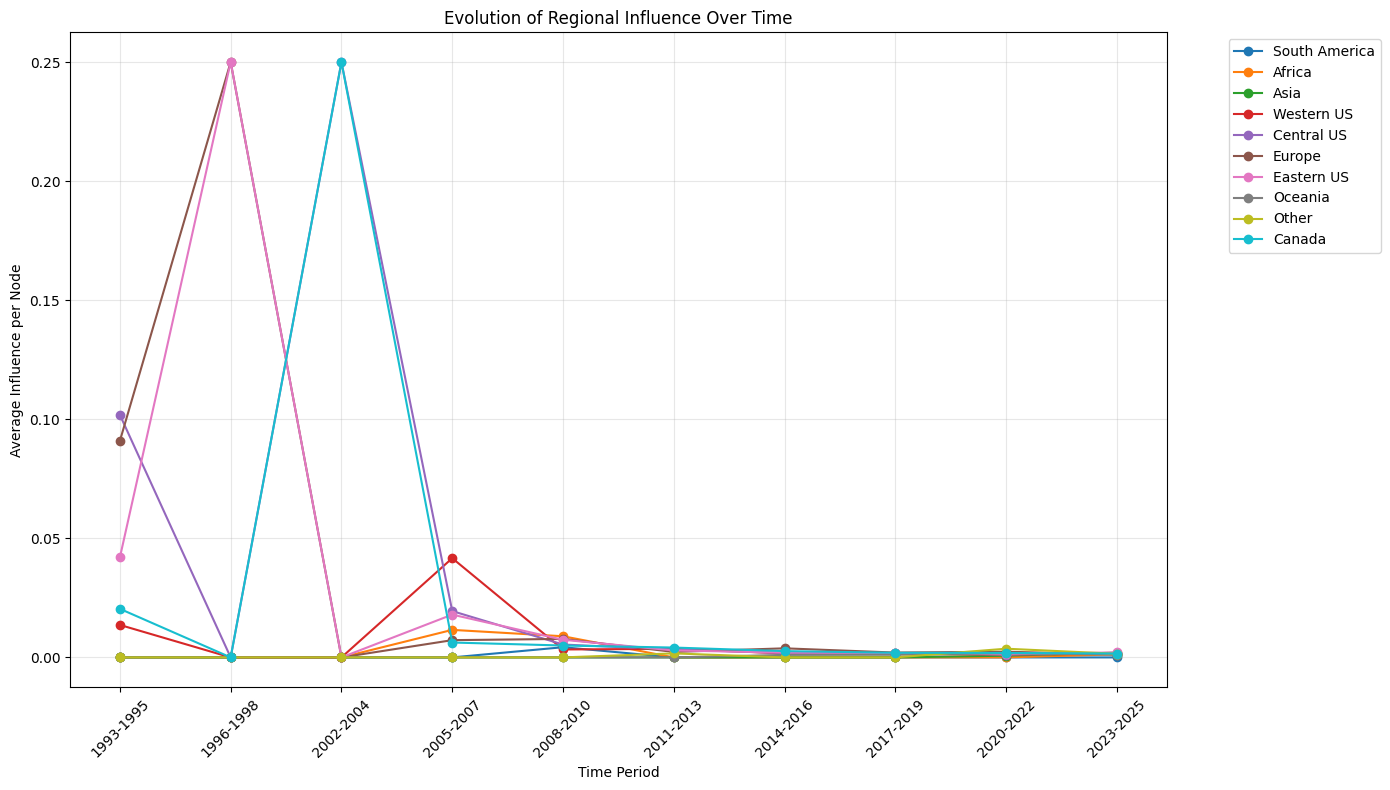


Period: 1993-1995
Top global bridges:
  - Turner-Smith, Ronald (Region: Europe, Bridge Score: 0.2273)
  - Lindley, Mark (Region: Eastern US, Bridge Score: 0.2273)
  - Hermann, Richard (Region: Western US, Bridge Score: 0.0682)
  - Robison, Brian (Region: Eastern US, Bridge Score: 0.0438)
  - Littlefield, Richard C. (Region: Central US, Bridge Score: 0.0341)


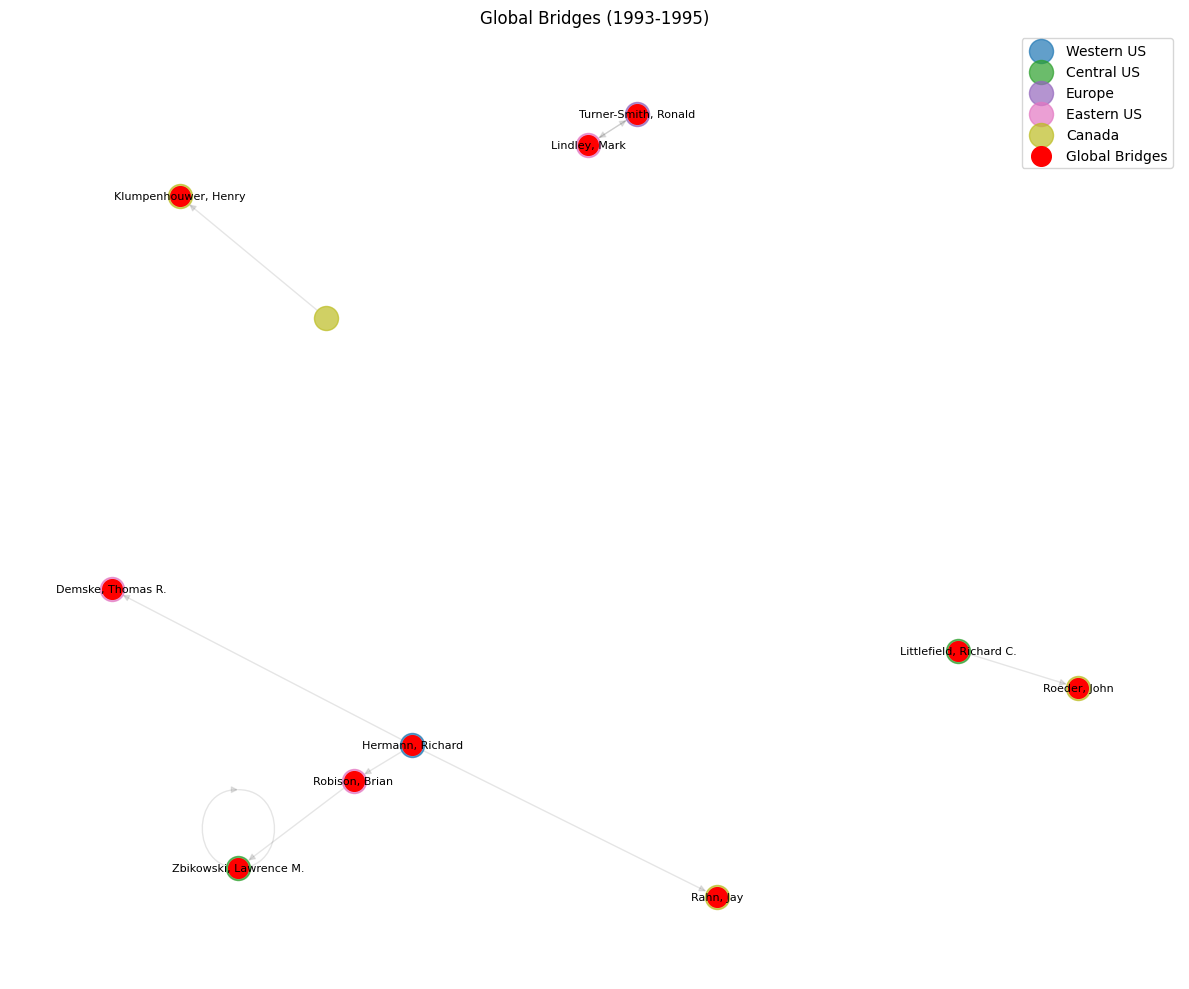


Period: 1996-1998
Top global bridges:
  - Brinkman, Alexander R. (Region: Eastern US, Bridge Score: 0.0000)
  - Douw, Andre M. (Region: Europe, Bridge Score: 0.0000)
  - Marvin, Elizabeth W. (Region: Eastern US, Bridge Score: 0.0000)
  - Schuijer, Michiel C. (Region: Europe, Bridge Score: 0.0000)


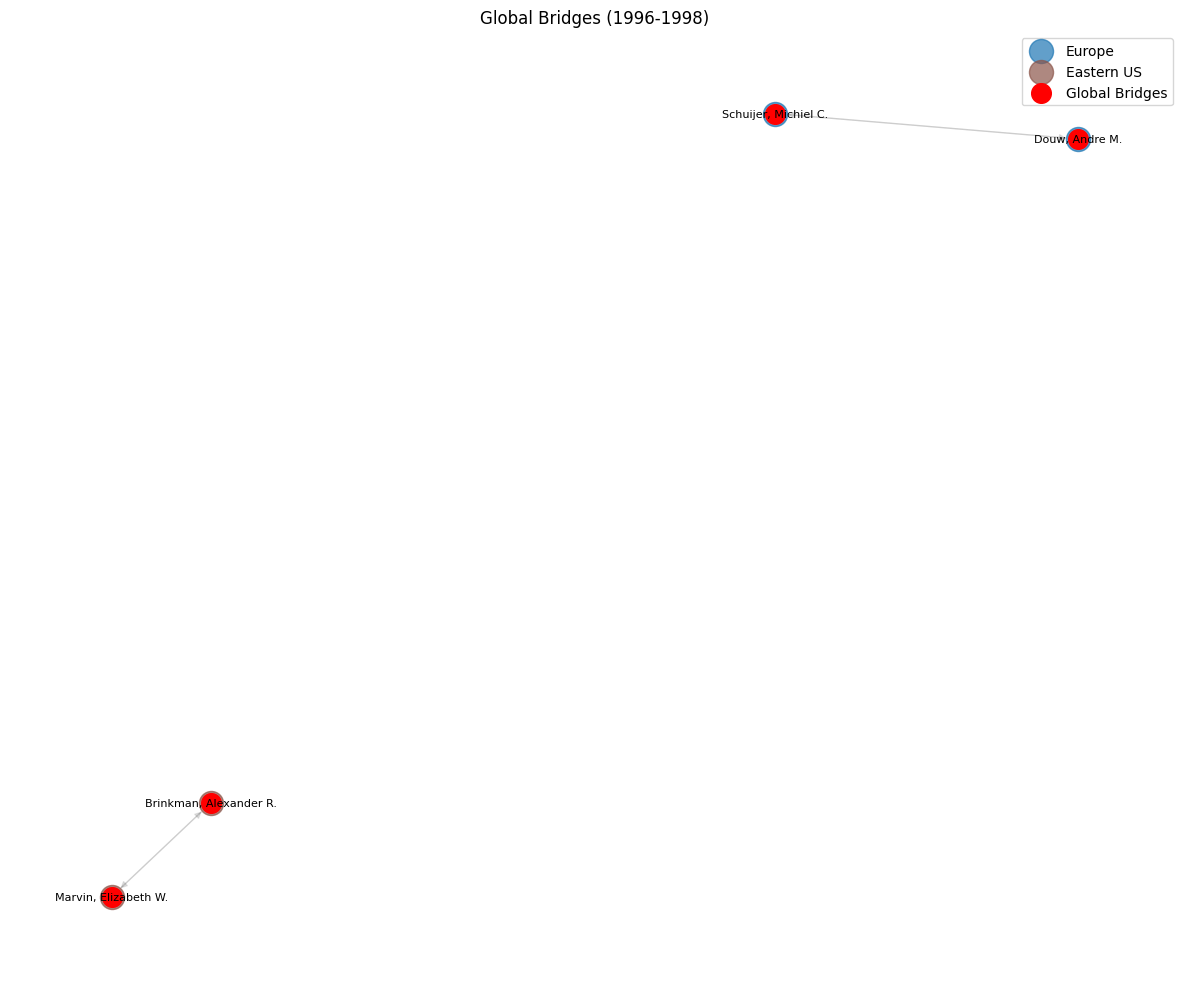


Period: 2002-2004
Top global bridges:
  - Woods, Alyssa (Region: Central US, Bridge Score: 2.5000)
  - Burns, Lori (Region: Canada, Bridge Score: 2.5000)
  - Hippel, Paul T. von (Region: Central US, Bridge Score: 0.0000)
  - Aarden, Bret (Region: Central US, Bridge Score: 0.0000)


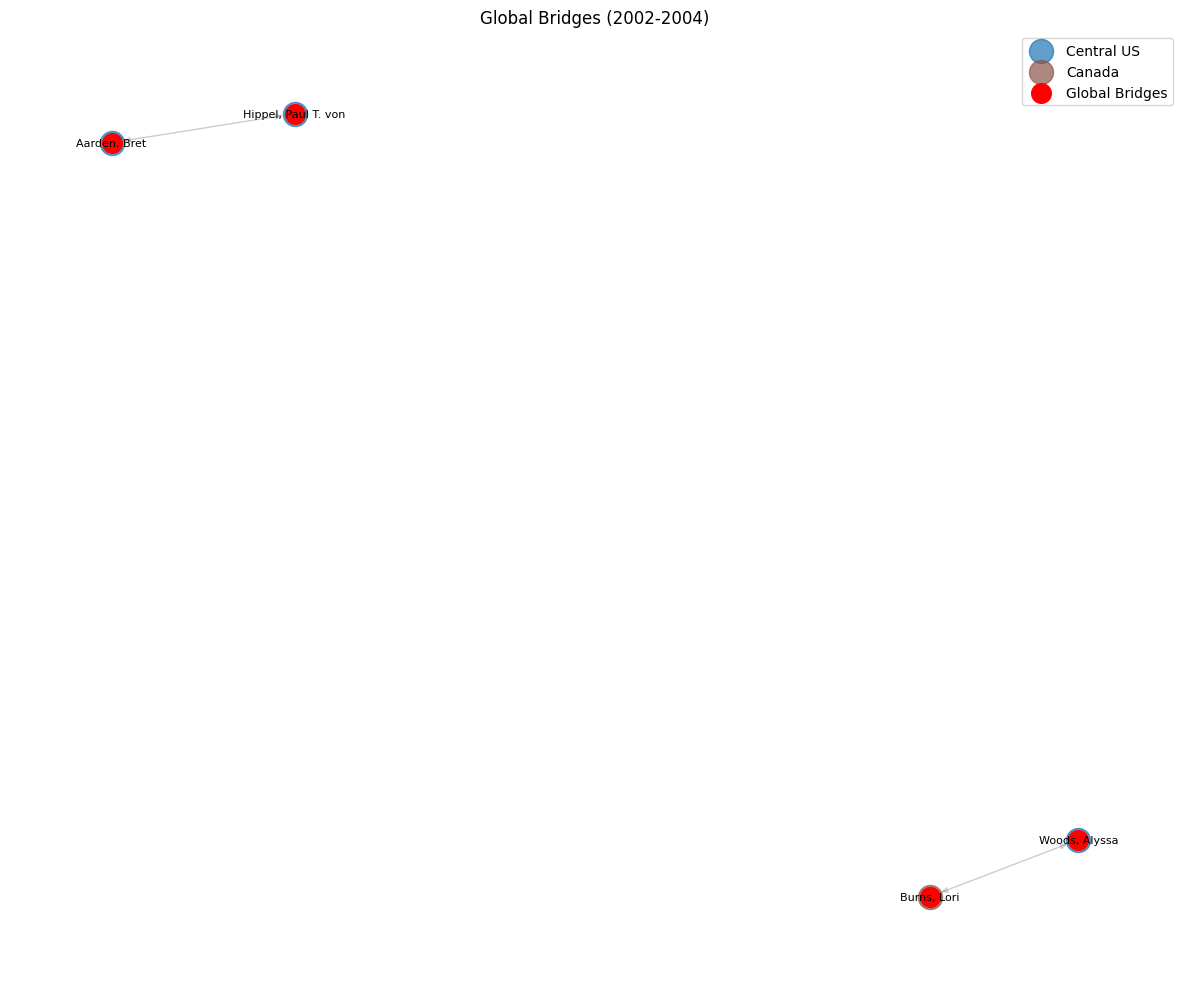


Period: 2005-2007
Top global bridges:
  - Nolan, Catherine (Region: Canada, Bridge Score: 0.0250)
  - Losada, C. Catherine (Region: Central US, Bridge Score: 0.0203)
  - Samplaski, Art (Region: Eastern US, Bridge Score: 0.0181)
  - Spicer, Mark (Region: Eastern US, Bridge Score: 0.0167)
  - Stoecker, Philip (Region: Central US, Bridge Score: 0.0125)


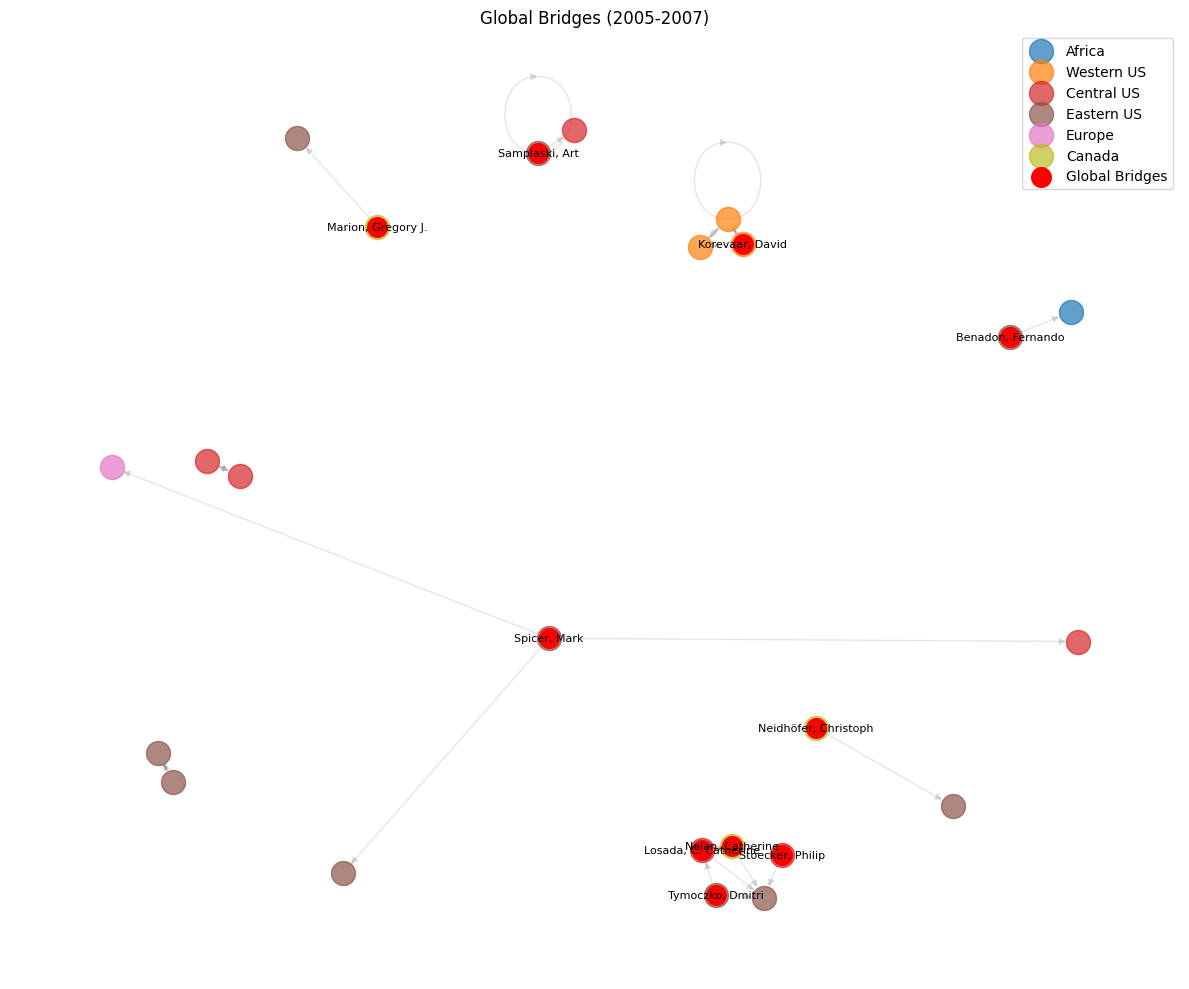


Period: 2008-2010
Top global bridges:
  - Roeder, John (Region: Canada, Bridge Score: 0.0241)
  - Donin, Nicolas (Region: Europe, Bridge Score: 0.0193)
  - Goldman, Jonathan (Region: Canada, Bridge Score: 0.0193)
  - Polak, Rainer (Region: Europe, Bridge Score: 0.0189)
  - Locke, David (Region: Eastern US, Bridge Score: 0.0184)


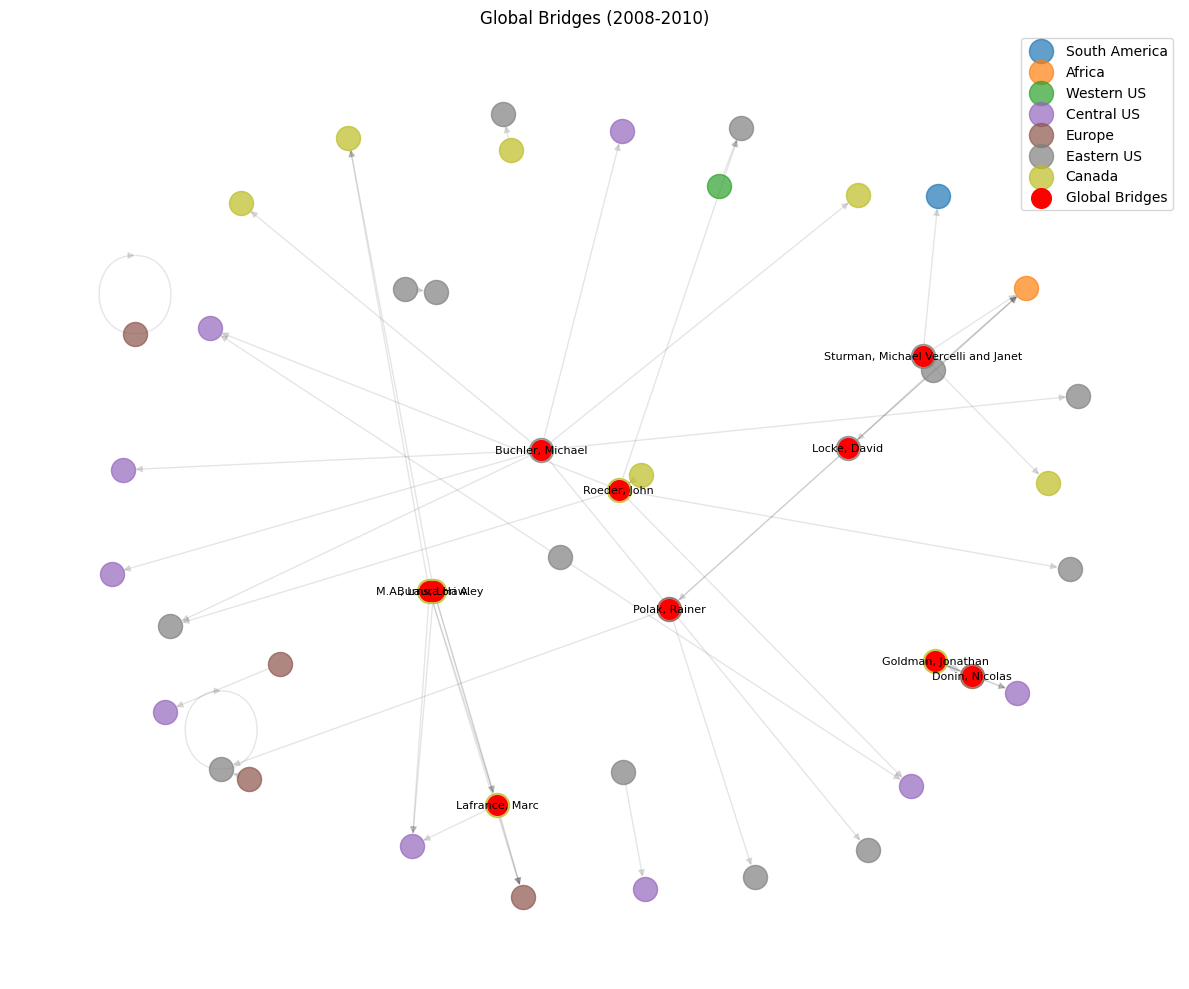


Period: 2011-2013
Top global bridges:
  - Lewis, George E. (Region: Eastern US, Bridge Score: 0.0197)
  - McFarland, Mark (Region: Eastern US, Bridge Score: 0.0116)
  - Moseley, Roger (Region: Eastern US, Bridge Score: 0.0101)
  - BaileyShea, Matthew L. (Region: Eastern US, Bridge Score: 0.0098)
  - Steinbeck, Paul (Region: Central US, Bridge Score: 0.0094)


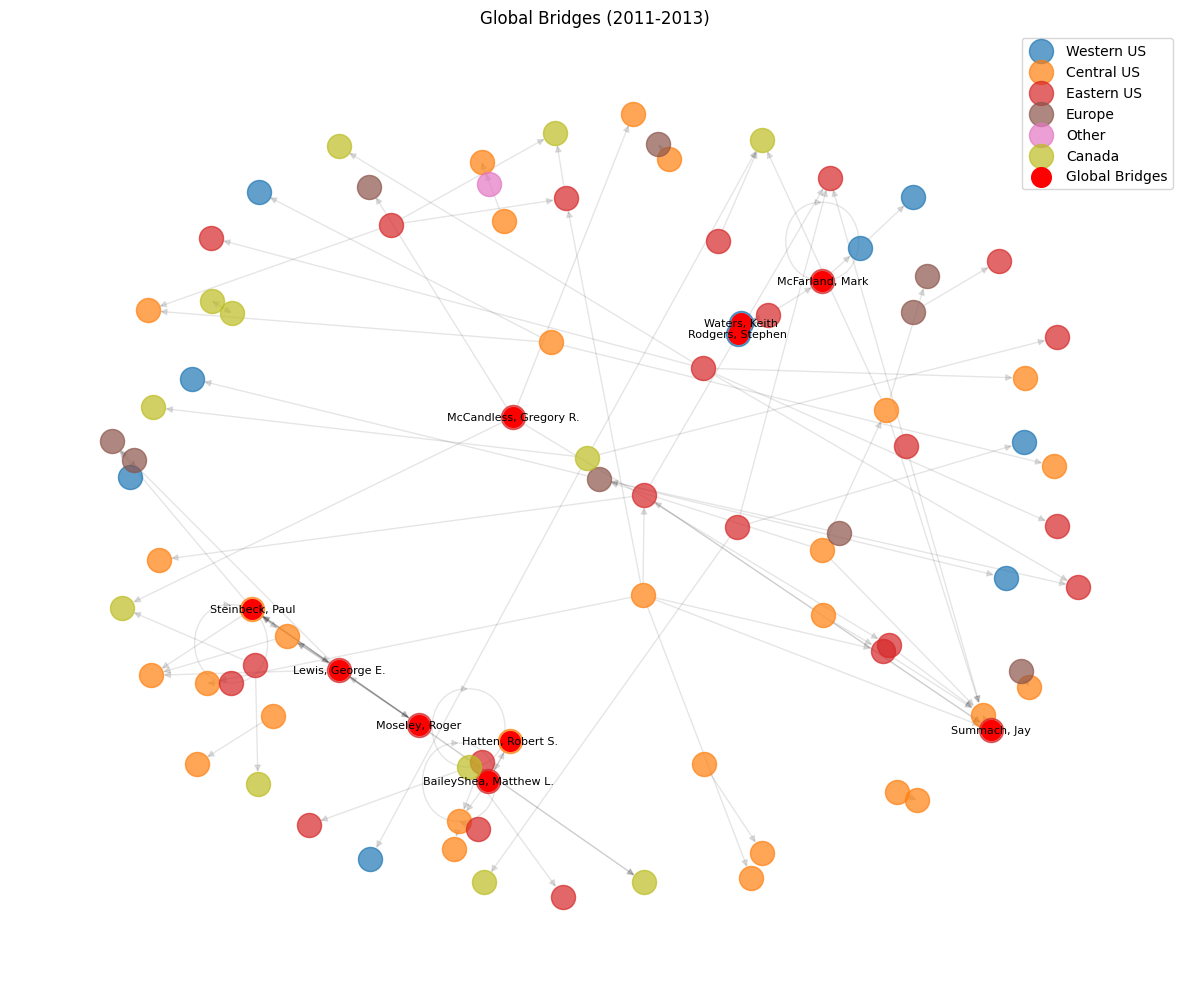


Period: 2014-2016
Top global bridges:
  - Polak, Rainer (Region: Europe, Bridge Score: 0.0182)
  - Shaffer, Kris P. (Region: Western US, Bridge Score: 0.0159)
  - Gawboy, Anna (Region: Central US, Bridge Score: 0.0157)
  - Cohn, Richard (Region: Eastern US, Bridge Score: 0.0112)
  - Gotham, Mark (Region: Europe, Bridge Score: 0.0110)


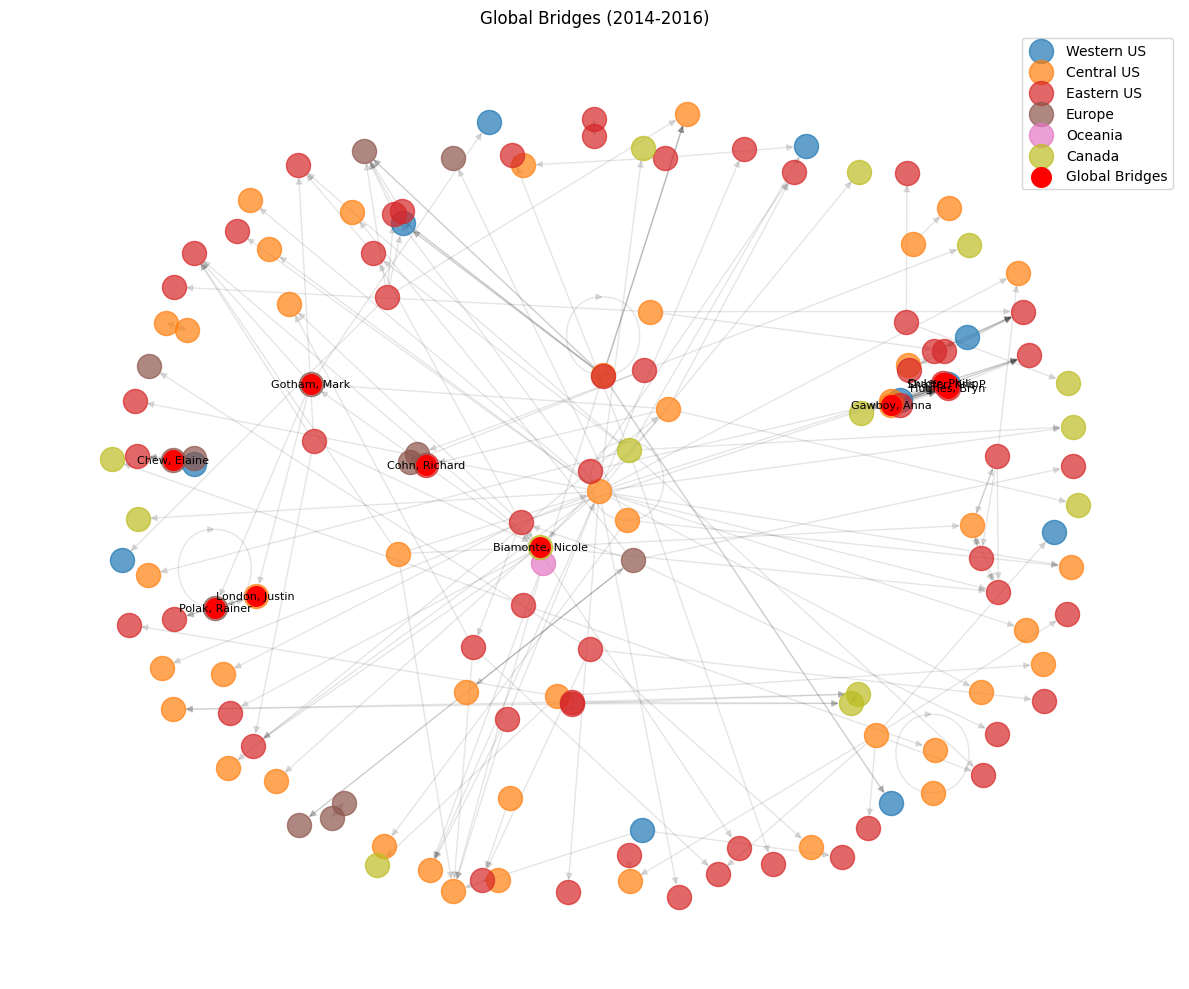


Period: 2017-2019
Top global bridges:
  - Ohriner, Mitchell S. (Region: Eastern US, Bridge Score: 0.0094)
  - Boone, Christine (Region: Central US, Bridge Score: 0.0079)
  - Bungert, James (Region: Western US, Bridge Score: 0.0072)
  - Duinker, Ben (Region: Canada, Bridge Score: 0.0068)
  - Lucas, Olivia R. (Region: Oceania, Bridge Score: 0.0067)


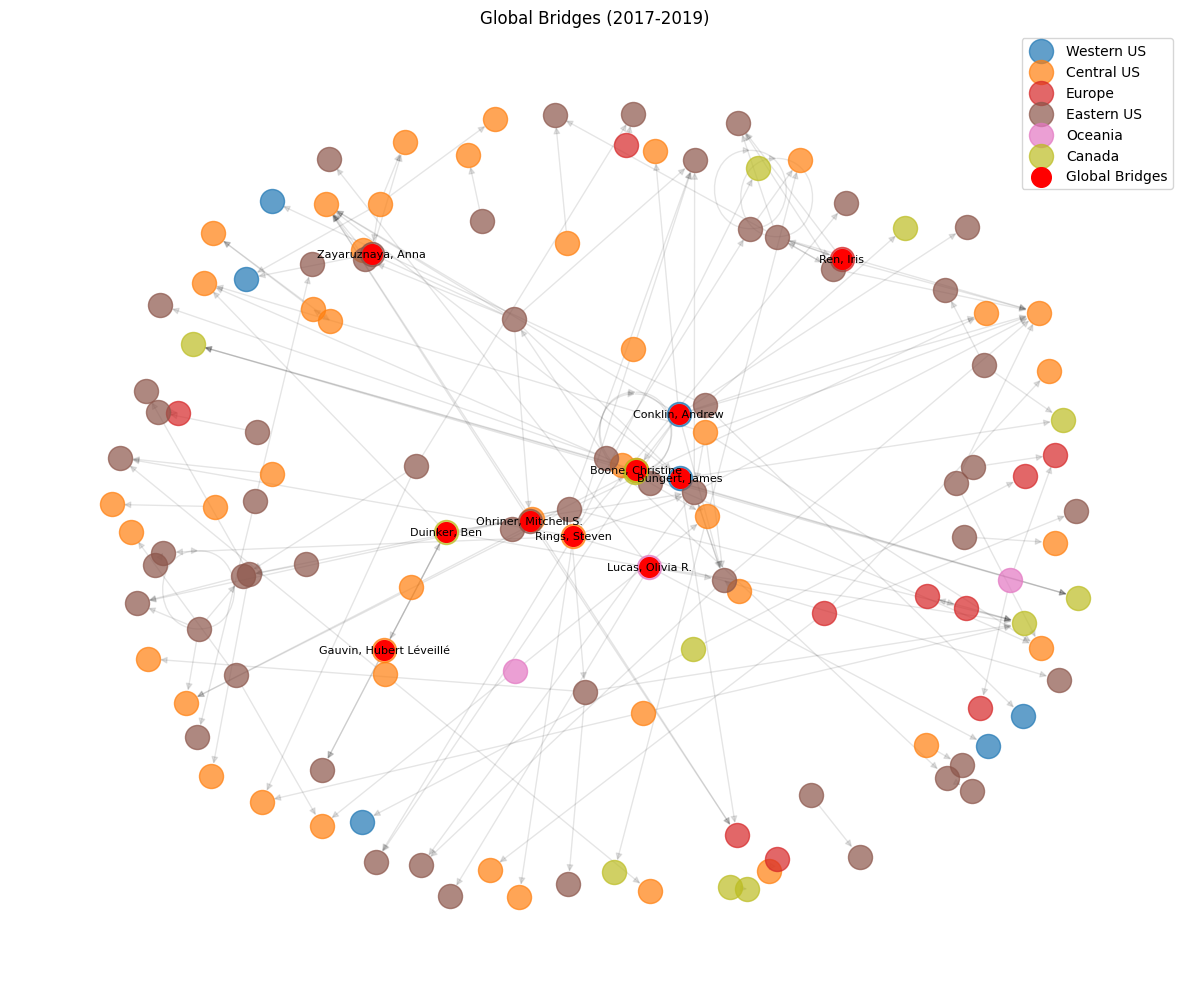


Period: 2020-2022
Top global bridges:
  - Emmery, Laura (Region: Eastern US, Bridge Score: 0.0069)
  - Levy, Benjamin R. (Region: Western US, Bridge Score: 0.0069)
  - Llorens, Ana (Region: Europe, Bridge Score: 0.0062)
  - Lucas, Olivia R. (Region: Oceania, Bridge Score: 0.0059)
  - Duinker, Ben (Region: Canada, Bridge Score: 0.0053)


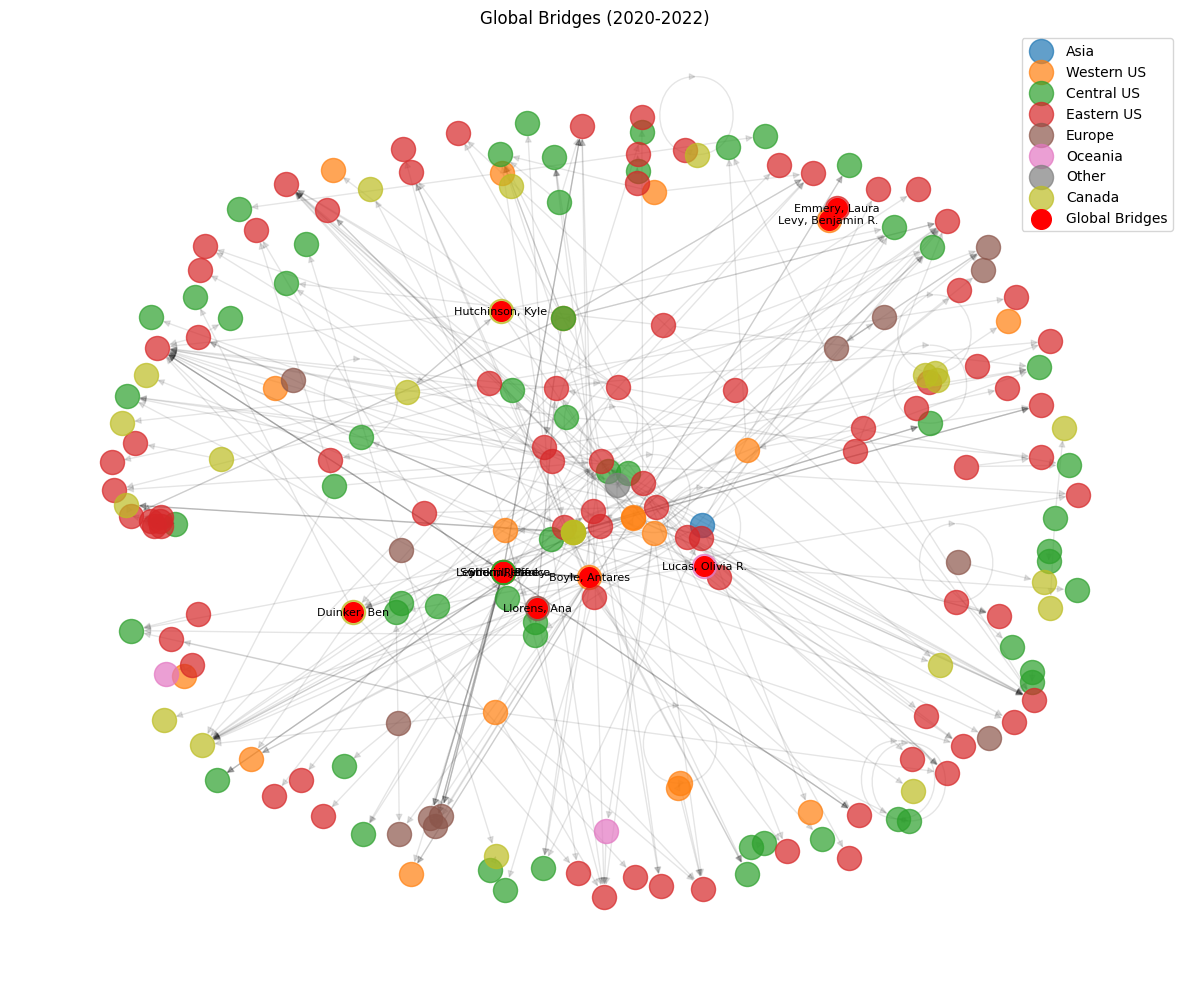


Period: 2023-2025
Top global bridges:
  - Biamonte, Nicole (Region: Canada, Bridge Score: 0.0090)
  - Duinker, Ben (Region: Canada, Bridge Score: 0.0075)
  - Zeller, Matthew (Region: Western US, Bridge Score: 0.0074)
  - VanHandel, Leigh (Region: Canada, Bridge Score: 0.0068)
  - Shea, Nicholas (Region: Western US, Bridge Score: 0.0065)


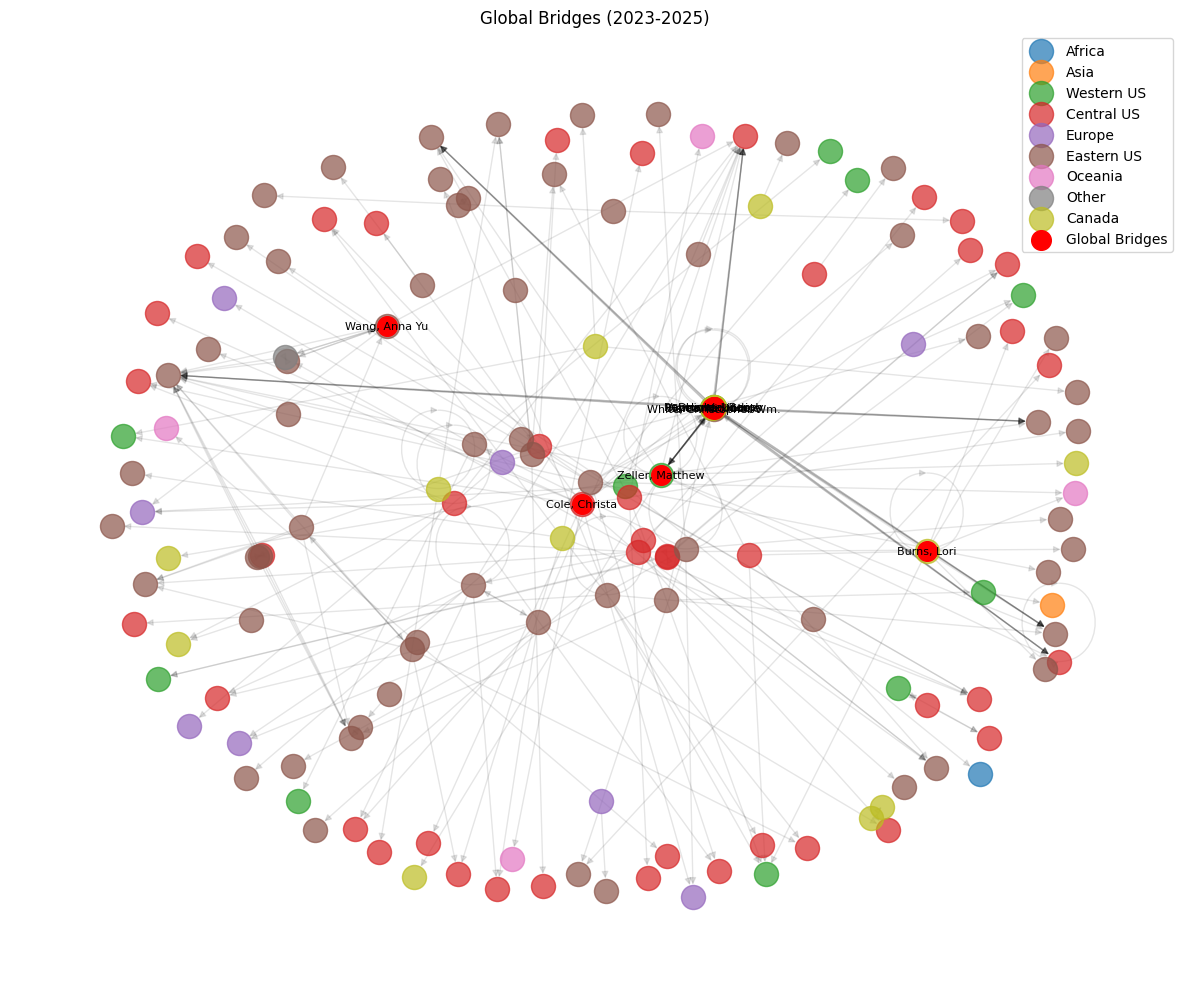

In [412]:
global_bridges()

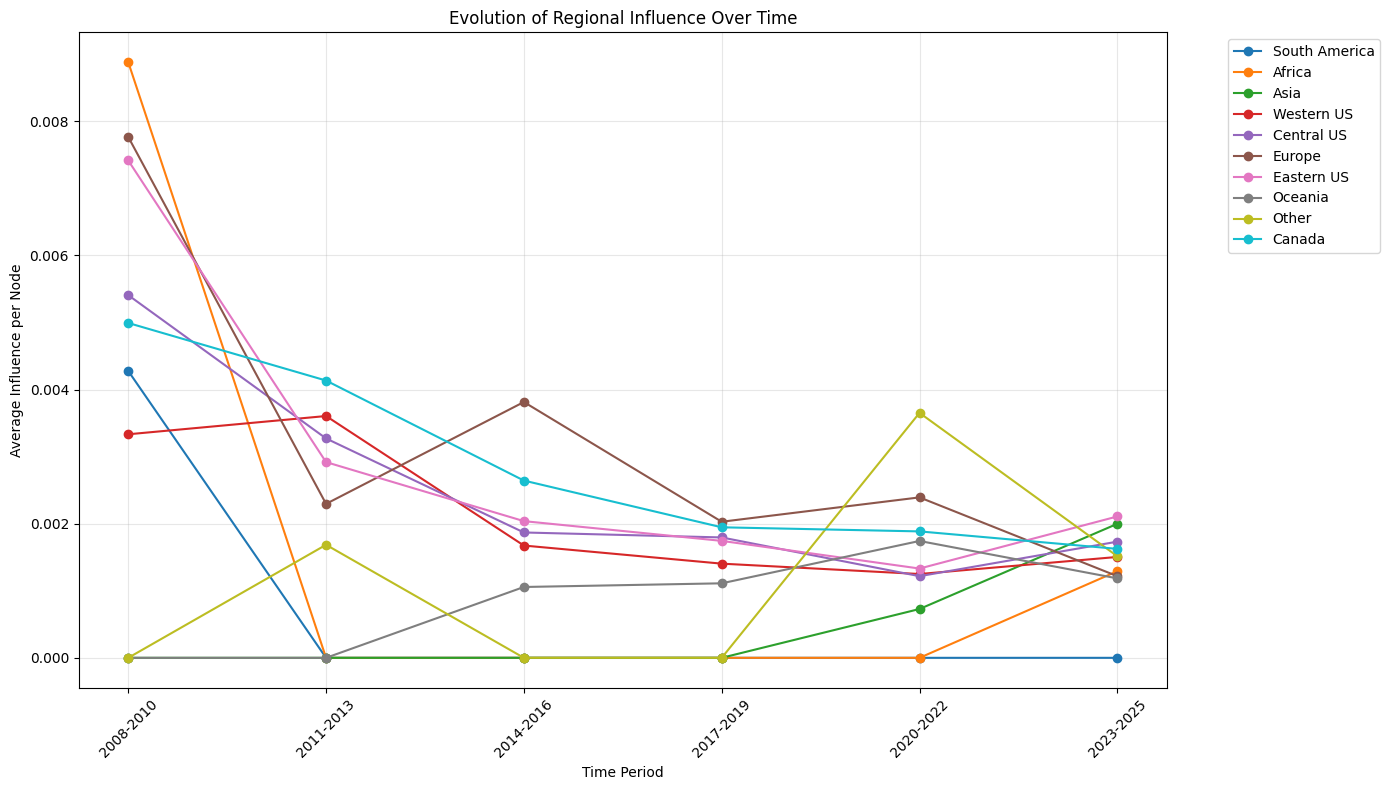

In [413]:
# for closer look
global_bridges(start = 2008, only_evo = True)